In [27]:
import imageio.v3 as iio
import matplotlib.pyplot as plt
import numpy as np
import plotly.io
import plotly.express as px
from scipy import sparse

import skimage as ski


In [13]:
#####################################################################
# The dataset we are using in this example is an image sequence (a movie!) of
# human in-vivo tissue. Specifically, it shows the *palisades of Vogt* of a
# given cornea sample.

#####################################################################
# Load image data
# ===============

# image_seq = ski.data.palisades_of_vogt()  # This doesn't work on my machine yet. 
image_seq = iio.imread('data/raw.tiff')

print(f'number of dimensions: {image_seq.ndim}')
print(f'shape: {image_seq.shape}')
print(f'dtype: {image_seq.dtype}')

number of dimensions: 3
shape: (60, 554, 572)
dtype: uint8


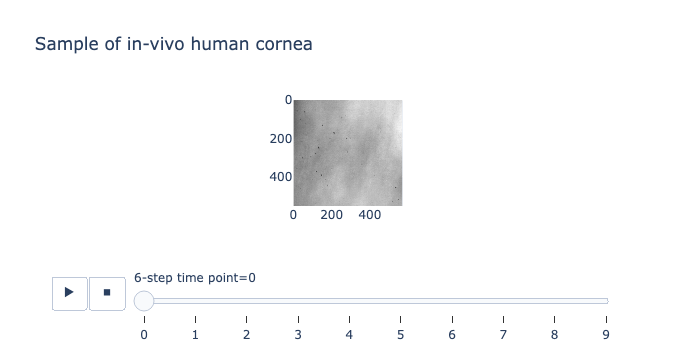

In [14]:
# The dataset is an image stack with 60 frames (time points) and 2 spatial
# dimensions. Let us visualize 10 frames by sampling every six time points:
# We can see some changes in illumination.
# We take advantage of the ``animation_frame`` parameter in
# Plotly's ``imshow`` function. As a side note, when the
# ``binary_string`` parameter is set to ``True``, the image is
# represented as grayscale.

fig = px.imshow(
    image_seq[::6, :, :],
    animation_frame=0,
    binary_string=True,
    labels={'animation_frame': '6-step time point'},
    title='Sample of in-vivo human cornea'
)
plotly.io.show(fig)

shape: (554, 572)


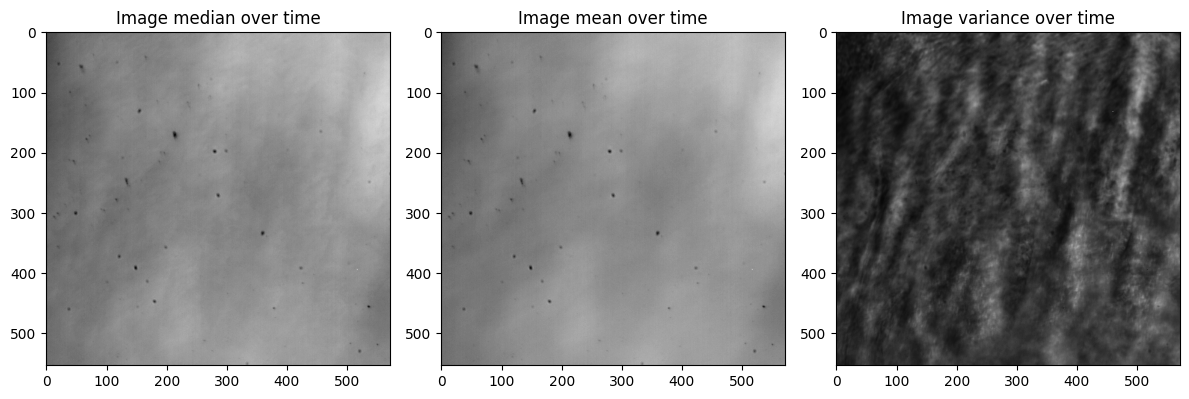

In [52]:
#####################################################################
# Aggregate over time
# ===================
# First, we want to detect those dirt spots where the data are lost. In
# technical terms, we want to *segment* the dirt spots (for
# all frames in the sequence). Unlike the actual data (signal), the dirt spots
# do not move from one frame to the next; they are still. Therefore, we begin
# by computing a time aggregate of the image sequence. We shall use the median
# image to segment the dirt spots, the latter then standing out
# with respect to the background (blurred signal).
# Complementarily, to get a feel for the (moving) data, let us compute the
# variance.

image_med = np.median(image_seq, axis=0)
image_mean = np.mean(image_seq, axis=0)
image_var = np.var(image_seq, axis=0)

assert image_mean.shape == image_med.shape

print(f'shape: {image_med.shape}')

fig, ax = plt.subplots(ncols=3, figsize=(12, 6))

ax[0].imshow(image_med, cmap='gray')
ax[0].set_title('Image median over time')
ax[1].imshow(image_mean, cmap='gray')
ax[1].set_title('Image mean over time')
ax[2].imshow(image_var, cmap='gray')
ax[2].set_title('Image variance over time')

fig.tight_layout()

In [53]:
#####################################################################
# Use local thresholding
# ======================
# To segment the dirt spots, we use thresholding. The images we are working
# with have uneven illumination, which causes variations in the (absolute)
# intensities of the foreground and the background, from one region to another
# (distant) one. It is therefore more fitting to compute different threshold
# values across the image, one for each region. This is called adaptive (or
# local) thresholding, as opposed to the usual thresholding procedure which
# employs a single (global) threshold for all pixels in the image.
#
# When calling the ``threshold_local`` function from the ``filters`` module,
# we may change the default neighborhood size (``block_size``), i.e., the
# typical size (number of pixels) over which illumination varies,
# as well as the ``offset`` (shifting the neighborhood's weighted mean).
# Let us try two different values for ``block_size``:


thresh_1 = ski.filters.threshold_local(image_med, block_size=21, offset=10.0)
thresh_2 = ski.filters.threshold_local(image_med, block_size=39, offset=10.0)

mask_1 = image_med < thresh_1
mask_2 = image_med < thresh_2

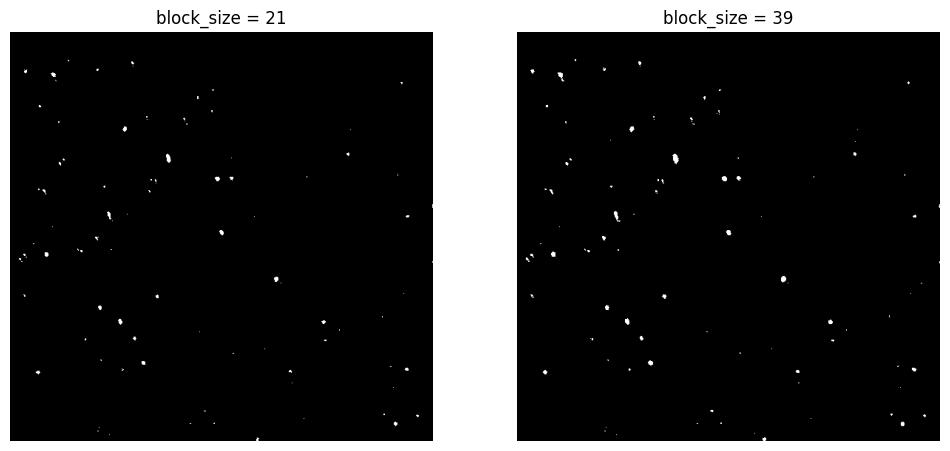

In [44]:
#####################################################################
# Let us define a convenience function to display two plots side by side, so
# it is easier for us to compare them:

def plot_comparison(plot1, plot2, title1, title2):
    fig, (ax1, ax2) = plt.subplots(
        ncols=2,
        figsize=(12, 8),
        sharex=True,
        sharey=True
    )
    ax1.imshow(plot1, cmap='gray')
    ax1.set_title(title1)
    ax1.axis('off')
    ax2.imshow(plot2, cmap='gray')
    ax2.set_title(title2)
    ax2.axis('off')

plot_comparison(mask_1, mask_2, "block_size = 21", "block_size = 39")

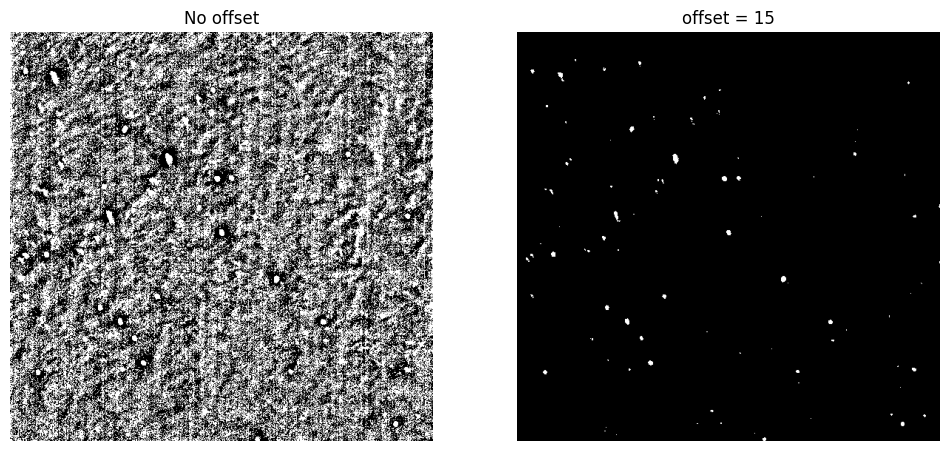

In [45]:
#####################################################################
# The "dark spots" appear to be more distinct in the second mask, i.e., the
# one resulting from using the larger ``block_size`` value.
# Regarding the value of the offset parameter, we noticed that increasing it
# instead of keeping its default zero value, would yield a more uniform
# background, hence letting the objects of interest stand out more visibly.
# Indeed:

thresh_0 = ski.filters.threshold_local(image_med, block_size=39)

mask_0 = image_med < thresh_0

plot_comparison(mask_0, mask_2, "No offset", "offset = 15")

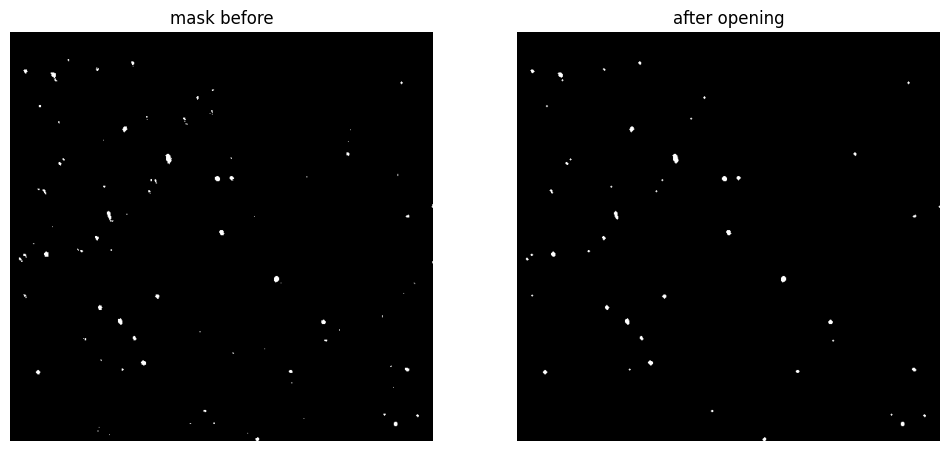

In [46]:
#####################################################################
# Remove fine-grained features
# ============================
# We use morphological filters to sharpen the mask and focus on the dark
# spots. The two fundamental morphological operators are *dilation* and
# *erosion*, where dilation (resp. erosion) sets the pixel to the brightest
# (resp. darkest) value of the neighborhood defined by a structuring element
# (footprint).
#
# Here, we use the ``diamond`` function from the ``morphology`` module to
# create a diamond-shaped footprint.
# An erosion followed by a dilation is called an *opening*.
# First, we apply an opening filter, in order to remove small objects and thin
# lines, while preserving the shape and size of larger objects.

footprint = ski.morphology.diamond(1)
mask_open = ski.morphology.opening(mask_2, footprint)
plot_comparison(mask_2, mask_open, "mask before", "after opening")

In [21]:
#####################################################################
# Since "opening" an image starts with an erosion operation, bright regions
# which are smaller than the structuring element have been removed.
# Let us try now with a larger footprint:

# footprint = morphology.diamond(1)
# mask_open = morphology.opening(mask_2, footprint)
# plot_comparison(mask_2, mask_open, "mask before", "after opening")

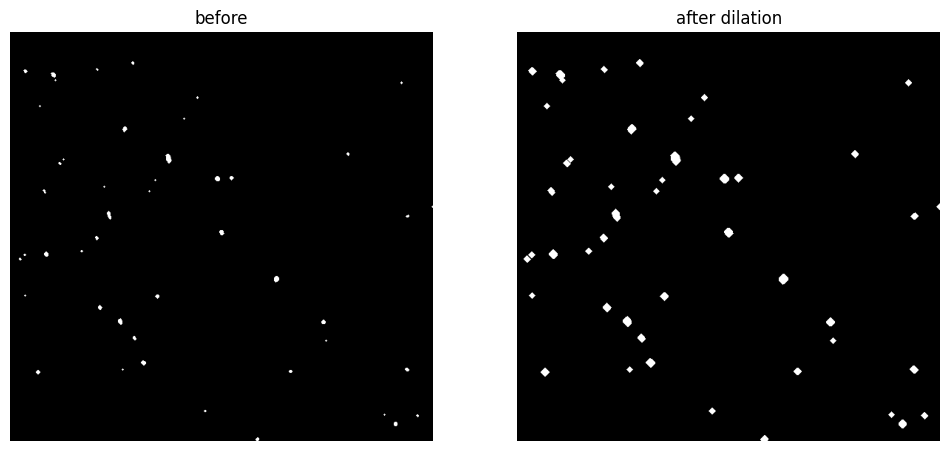

In [47]:
#####################################################################
# We can see that, with respect to the previous comparison plot, fewer spots
# are retained in the mask: The smaller ones have been filtered out, leaving
# only the larger ones.
# Next, we can make the detected areas wider by applying a dilation filter:
footprint = ski.morphology.diamond(3) # use a larger footprint for dilation
mask_dilate = morphology.dilation(mask_open, footprint)
plot_comparison(mask_open, mask_dilate, "before", "after dilation")

In [48]:
#####################################################################
# Inpaint each frame separately
# =============================
# We are now ready to apply inpainting to each frame. For this we use function
# ``inpaint_biharmonic`` from the ``restoration`` module. It implements an
# algorithm based on biharmonic equations.
# This function takes two arrays as inputs:
# The image to restore and a mask (with same shape) corresponding to the
# regions we want to inpaint.

image_seq_inpainted = np.zeros(image_seq.shape)
for i in range(image_seq.shape[0]):
    image_seq_inpainted[i] = ski.restoration.inpaint_biharmonic(
        image_seq[i],
        mask_dilate
    )

In [49]:
#####################################################################
# Let us visualize one restored image, where the dirt spots have been
# inpainted. First, we find the contours of the dirt spots (well, of the mask)
# so we can draw them on top of the restored image:

contours = ski.measure.find_contours(mask_dilate)

# Gather all (row, column) coordinates of the contours
x = []
y = []
for contour in contours:
    x.append(contour[:, 0])
    y.append(contour[:, 1])
# Flatten them
x_flat = np.concatenate(x).ravel()
y_flat = np.concatenate(y).ravel()
# Create a sparse matrix corresponding to the mask of these contours
data = np.ones(x_flat.shape, dtype='bool')
mtx = sparse.coo_matrix((data, (x_flat, y_flat)), shape=mask_dilate.shape)
# Convert it to array
arr = mtx.toarray().astype('int')
# Pick one frame
sample_result = image_seq_inpainted[12]
# Normalize it (so intensity values range [0, 1])
sample_result /= sample_result.max()

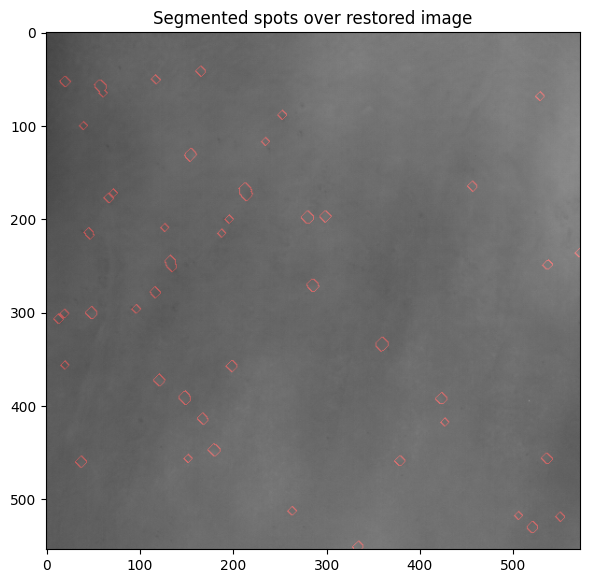

In [50]:
#####################################################################
# We use function ``label2rgb`` from the ``color`` module to overlay the
# restored image with the segmented spots, using transparency (alpha
# parameter).

color_contours = ski.color.label2rgb(
    arr,
    image=sample_result,
    alpha=0.4,
    bg_label=0
)

fig, ax = plt.subplots(figsize=(6, 6))

ax.imshow(color_contours)
ax.set_title('Segmented spots over restored image')

fig.tight_layout()
